In [ ]:
# Import required libraries for Hugging Face models and configuration
from langchain_huggingface.chat_models import ChatHuggingFace
from langchain_huggingface import HuggingFaceEndpoint
from pydantic_settings import BaseSettings
from typing import Optional

In [ ]:
# Configuration class to load environment variables from .env file
class EndpointSettings(BaseSettings):
    HF_TOKEN: str        # Hugging Face API token
    repo_id: str         # Model repository ID (e.g., "deepseek-ai/DeepSeek-V3.1")
    provider: str        # Provider name (e.g., "novita", "auto")
    temperature: float   # Controls randomness in model responses (0.0-1.0)

    class Config:
        env_file = "../.env"           # Path to environment file
        env_file_encoding = "utf-8"    # File encoding
        extra = "ignore"               # Ignore extra fields not defined in the class

In [ ]:
# Custom wrapper class for Hugging Face chat models
class HuggingFaceChatModel(ChatHuggingFace):
    def __init__(self):
        # Load configuration from environment variables
        config = EndpointSettings()

        # Create Hugging Face endpoint with loaded configuration
        llm = HuggingFaceEndpoint(
            repo_id=config.repo_id,                    # Model to use
            provider=config.provider,                  # Inference provider
            temperature=config.temperature,            # Response randomness
            huggingfacehub_api_token=config.HF_TOKEN  # Authentication token
        )

        # Initialize parent class with the configured endpoint
        super().__init__(llm=llm)

# Create an instance of our custom chat model
chat_model = HuggingFaceChatModel()

In [ ]:
# Import LangGraph components for building state machines
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages  # Helper for message accumulation
from typing_extensions import TypedDict
from typing import Annotated

In [ ]:
# Define the state structure for our graph
# TypedDict provides type hints for the state dictionary
class State(TypedDict):
    # Messages list with automatic accumulation using add_messages
    messages: Annotated[list, add_messages]

# Main chatbot function that processes user messages
def chatbot(state: State) -> State:
    # Bind tools to the chat model so it knows about available functions
    model_with_tools = chat_model.bind_tools(tools)
    # Invoke the model with current messages and return the response
    return {"messages": [model_with_tools.invoke(state["messages"])]}

In [ ]:
# Import tool decorator from LangChain
from langchain_core.tools import tool

# Define a weather tool function
@tool
def get_current_weather(location: str, unit: Optional[str] = "celsius") -> dict:
    """Get the current weather for a given location and unit."""
    # Simulate weather API response (in real app, would call actual weather API)
    weather_data = {
        "location": location,
        "temperature": 22,
        "unit": unit
    }
    return weather_data

# Define a stock price tool function
@tool
def get_stock_price(symbol: str) -> dict:
    """Get the current stock price for a given symbol."""
    # Simulate stock API response (in real app, would call actual stock API)
    stock_data = {
        "symbol": symbol,
        "price": 150.0
    }
    return stock_data

In [ ]:
# Import prebuilt components for tool handling
from langgraph.prebuilt import ToolNode, tools_condition

# Define tools list that will be available to the chatbot
# This must be defined before the chatbot function that references it
tools = [get_current_weather, get_stock_price]

In [ ]:
# Build the state graph for our chatbot with tool calling
builder = StateGraph(State)

# Add nodes to the graph
builder.add_node("chatbot", chatbot)           # Main chatbot node
builder.add_node("tools", ToolNode(tools))     # Tool execution node

# Define the graph flow
builder.add_edge(START, "chatbot")                          # Start with chatbot
builder.add_conditional_edges("chatbot", tools_condition)   # Conditionally go to tools if needed
builder.add_edge("tools", END)                              # Return to end after tool execution

# Compile the graph into a runnable workflow
graph = builder.compile()


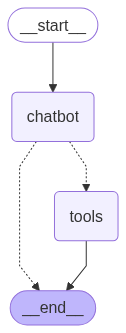

In [ ]:
# Visualize the graph structure
from IPython.display import display, Image

# Generate and display a visual representation of the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Test the chatbot with a query that should trigger tool usage
# This message asks for both weather and stock information, which should invoke our tools
state = graph.invoke({"messages": [{"role": "user", "content": "What's the weather like in New York and the stock price of AAPL?"}]})

In [ ]:
# Display the conversation messages to see the chatbot's responses
# This will show both user messages and AI responses, including any tool calls
state["messages"]

[HumanMessage(content="What's the weather like in New York and the stock price of AAPL?", additional_kwargs={}, response_metadata={}, id='1a8957b9-cee3-4dde-b2b8-5cc58236ab79'),
 AIMessage(content="I'll get both the weather in New York and the stock price of AAPL for you.", additional_kwargs={'tool_calls': [{'function': {'arguments': '{"location": "New York"}', 'name': 'get_current_weather', 'description': None}, 'id': 'call_dd7b5e83593d4acea9ff70cc', 'type': 'function'}, {'function': {'arguments': '{"symbol": "AAPL"}', 'name': 'get_stock_price', 'description': None}, 'id': 'call_7fe851b21c844272957a2e71', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 246, 'total_tokens': 296}, 'model_name': 'deepseek-ai/DeepSeek-V3.1', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bdb2fea7-a5b0-441b-b616-70421129ff86-0', tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'New York'}, 'id': 'call_

In [70]:
graph.invoke({"messages": [{"role": "user", "content": "Let me know what the question i asked?"}]})

{'messages': [HumanMessage(content='Let me know what the question i asked?', additional_kwargs={}, response_metadata={}, id='a77e6c86-0ab5-49ef-ba95-3b16242c0b89'),
  AIMessage(content="I don't see any previous question in our current conversation. We're just starting fresh! \n\nWhat would you like to know? I can help you get current weather information for any location or check current stock prices. Just let me know what you need!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 239, 'total_tokens': 291}, 'model_name': 'deepseek-ai/DeepSeek-V3.1', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run--aa109ea8-42c7-45ed-b384-83c673c32ea0-0', usage_metadata={'input_tokens': 239, 'output_tokens': 52, 'total_tokens': 291})]}

💡 Why the chatbot said “I don’t see any previous question”

Each time you call graph.invoke(...) with only a new user message, it starts with a fresh state. That means the model only sees the messages you pass in during that call.

add_messages makes sure messages are appended within one run of the graph (so the conversation grows during tool calls + AI responses).

But if you want the chatbot to remember past turns across multiple calls, you must pass the full conversation history back in:

### First user turn
state = graph.invoke({"messages": [{"role": "user", "content": "What's the weather in New York?"}]})

### Next user turn – reuse the whole history
state = graph.invoke({
    "messages": state["messages"] + [{"role": "user", "content": "What did I just ask?"}]
})
